# Building a fashion search engine with `docarray`

Previously we built a simple fashion search engine using Docarray. Now we've fine-tuned the model for better performance, let's go ahead and load it up!

## Configuration

We'll set up some basic variables. Feel free to adapt these for your own project!

In [1]:
DATA_DIR = "./data"
DATA_PATH = f"{DATA_DIR}/images/*.jpg"
MAX_DOCS = 1000
TUNED_MODEL_NAME = "./tuned-model"
QUERY_IMAGE = "./query.jpg" # image we'll use to search with
PLOT_EMBEDDINGS = False # Really useful but have to manually stop it to progress to next cell

# Toy data - If data dir doesn't exist, we'll get data of ~800 fashion images from here
TOY_DATA_URL = "https://github.com/alexcg1/neural-search-notebooks/blob/main/docarray/fashion-search/data.zip?raw=true"

## Setup

In [2]:
# We use "[full]" because we want to deal with more complex data like images (as opposed to text)
!pip install "docarray[full]"

In [3]:
from docarray import Document, DocumentArray

## Load images

In [4]:
# Download images if they don't exist
import os

if not os.path.isdir(DATA_DIR) and not os.path.islink(DATA_DIR):
    print(f"Can't find {DATA_DIR}. Downloading toy dataset")
    !wget "$TOY_DATA_URL" -O data.zip
    !unzip -q data.zip # Don't print out every darn filename
    !rm -f data.zip
else:
    print(f"Nothing to download. Using {DATA_DIR} for data")

Nothing to download. Using ./data for data


In [5]:
# Use `.from_files` to quickly load them into a `DocumentArray`
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)
print(f"{len(docs)} Documents in DocumentArray")

845 Documents in DocumentArray


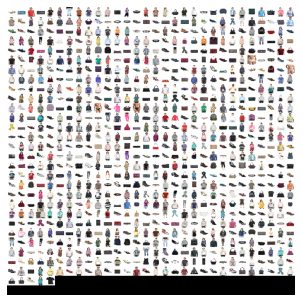

In [6]:
docs.plot_image_sprites() # Preview the images

## Apply preprocessing

In [7]:
from docarray import Document

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [8]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 845                                   
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   845              False            
  uri         ('str',)       845              False

## Embed images

In [9]:
!pip install torchvision -q

In [10]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu" # Change to "cpu" if you don't have GPU (it'll still run fine, just a bit slower)

In [11]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [12]:
docs.embed(model, device=device)

                             Documents Summary                              
                                                                            
  Length                 845                                                
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    845              False            
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       845              False            
  uri         ('ndarray',)   845              False

### Visualize embeddings

In [13]:
if PLOT_EMBEDDINGS:
    docs.plot_embeddings(image_sprites=True, image_source="uri")

## Create query Document

Let's just use the first image from our dataset:

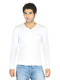

In [14]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [15]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [16]:
# Apply same preprocessing
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [17]:
# ...and create embedding just like we did with the dataset
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       1                False            
  uri         ('ndarray',)   1                False

## Get matches

In [18]:
query_docs.match(docs, limit=9)

## See the results

As you can see, the model is finding matches based on the input images - including the human wearing the clothes! In reality we want to match the clothes themselves, so later we'll fine-tune our model using Jina AI's [finetuner](https://finetuner.jina.ai).

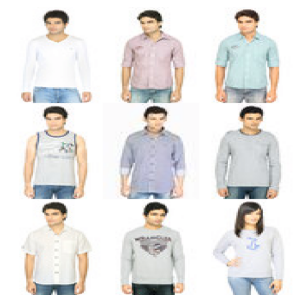

In [19]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()

In [20]:
if PLOT_EMBEDDINGS:
    query_doc.matches.plot_embeddings(image_sprites=True, image_source="uri")

## Next steps

### Finetuning our model

![](https://finetuner.jina.ai/_images/labeler-on-fashion-mnist.gif)

In our next notebook we'll improve our model's performance with **[Jina Finetuner](https://finetuner.jina.ai)**

### Building into a real world application

![](https://github.com/alexcg1/jina-multimodal-fashion-search/raw/main/demo.gif)

In a future notebook we'll use **[Jina's neural search framework](https://github.com/jina-ai/jina/)** and **[Jina Hub Executors](https://hub.jina.ai)** to build a [real world fashion search engine](http://examples.jina.ai/fashion) with minimal lines of code.

- [Finetune](https://finetuner.jina.ai) our model to improve matching
- Build into a real-world search engine with [Jina](https://github.com/jina-ai/jina) (example [here](http://examples.jina.ai/fashion))